## Imports:

In [1]:
import scipy
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt_lab
import matplotlib.gridspec as gridspec
import obspy
import pandas as pd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load data:
We are going to use this data to plot spectograms of SCG signals. 

In [3]:
dir_path = "/Users/ecem/Documents/GitHub/seismocardiogram/data/diseased-dataset"

In [4]:
h_x = np.load(dir_path + "/healty_x.npy", allow_pickle= True)

In [5]:
d_x = np.load(dir_path + "/diseased_x.npy", allow_pickle= True)

In [6]:
stacked_x = np.hstack((h_x,d_x))

In [7]:
stacked_x[0].stats.npts

525

In [8]:
stacked_x[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 1970-01-01T00:00:00.000000Z
         endtime: 1970-01-01T00:00:02.046875Z
   sampling_rate: 256.0
           delta: 0.00390625
            npts: 525
           calib: 1.0
      processing: ["ObsPy 1.3.0: detrend(options={}::type='linear')", "ObsPy 1.3.0: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')"]

In [10]:
obspy.core.utcdatetime.UTCDateTime("1970-01-01T00:00:02.046875Z")

1970-01-01T00:00:02.046875Z

## Trim 

In [7]:
npts = []
for i in range(len(stacked_x)):
    npts.append(stacked_x[i].stats.npts)

In [8]:
min(npts)

230

In [9]:
max(npts)

1066

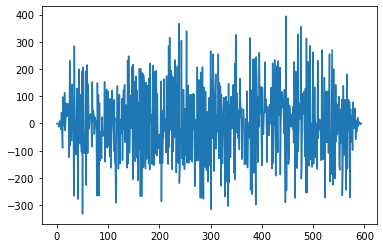

In [10]:
plt.plot(stacked_x[1])

In [11]:
trimmed = stacked_x[1].trim(stacked_x[1].stats.starttime , stacked_x[1].stats.starttime + 230 * 0.00390625)

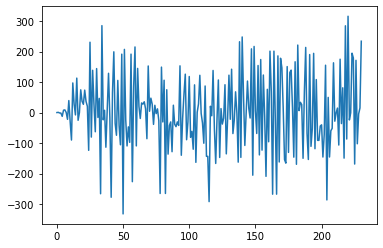

In [12]:
plt.plot(trimmed)

In [13]:
for i in range(len(stacked_x)):
    delta = stacked_x[i].stats.delta
    st = stacked_x[i].stats.starttime
    stacked_x[i] = stacked_x[i].trim(st, st + 230 * delta)

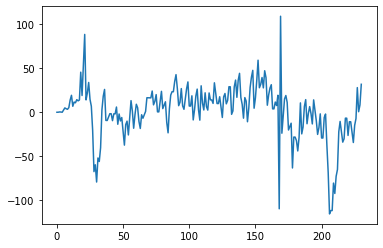

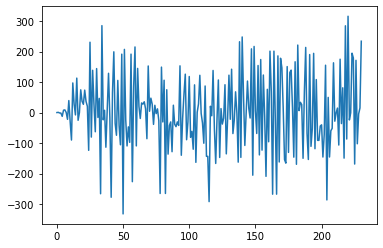

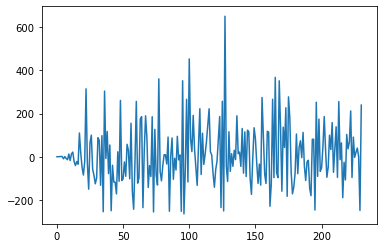

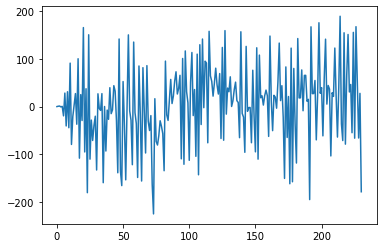

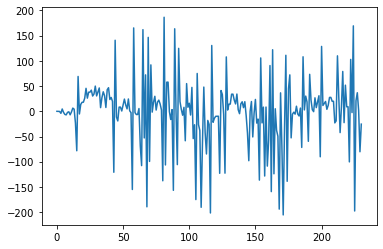

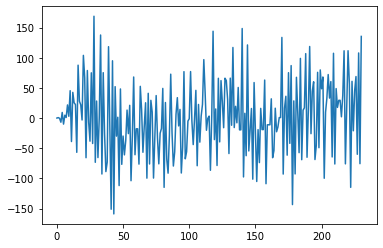

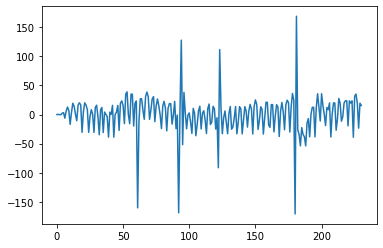

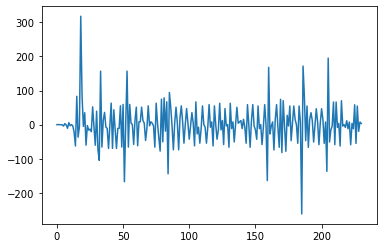

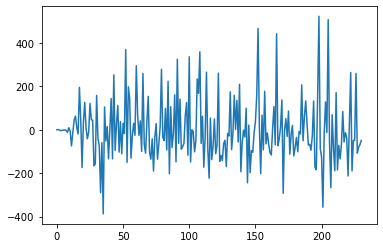

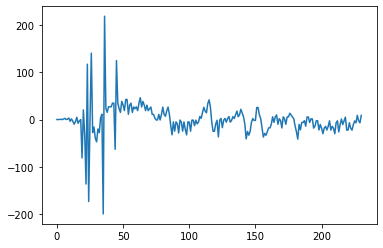

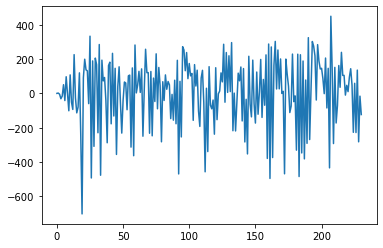

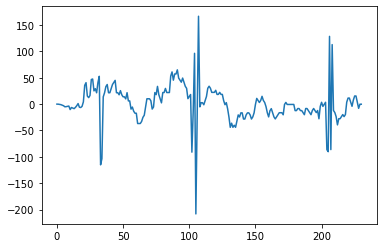

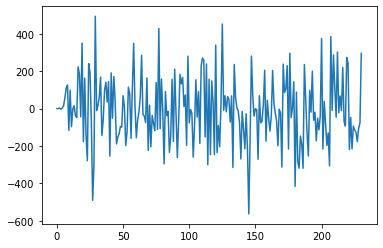

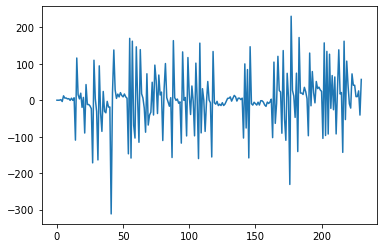

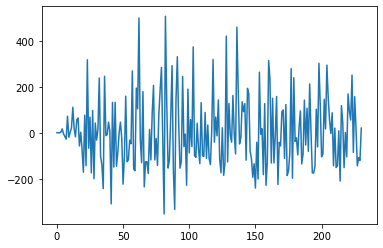

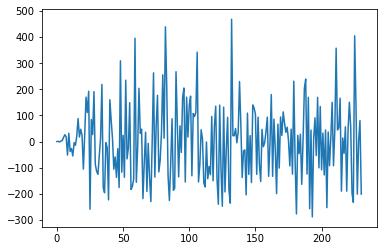

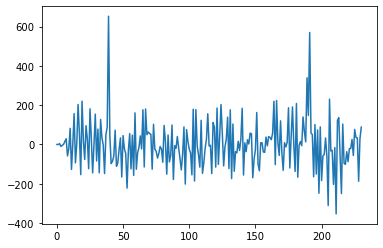

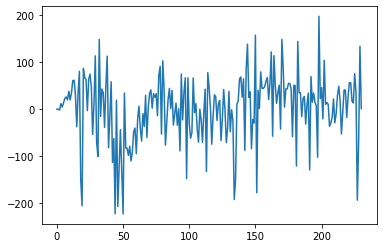

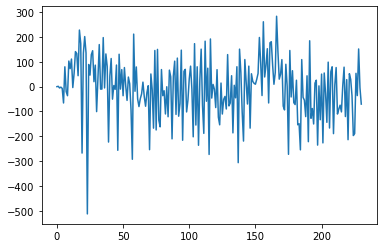

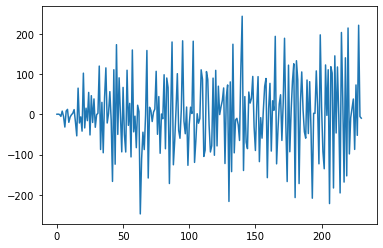

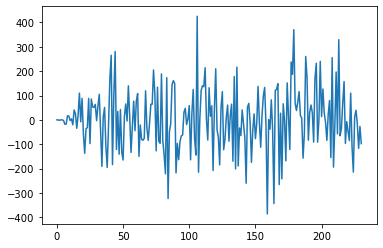

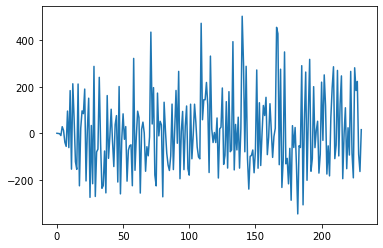

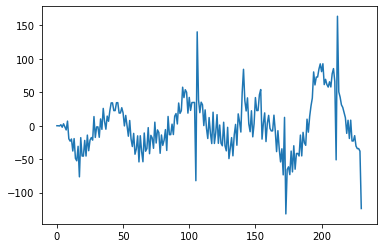

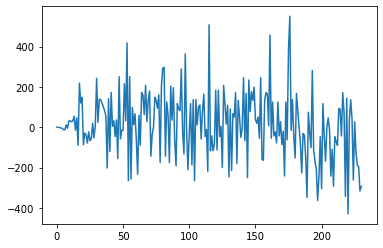

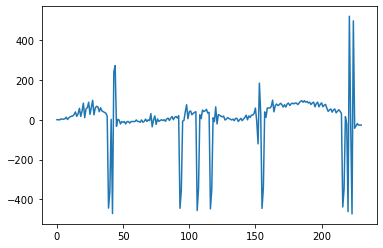

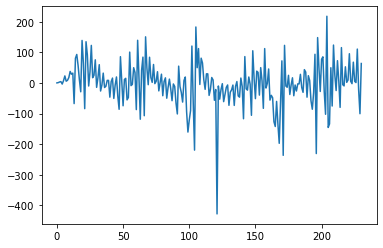

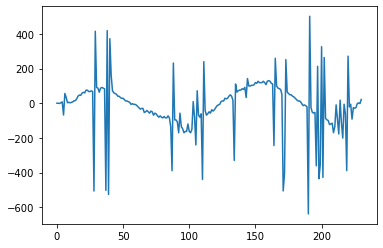

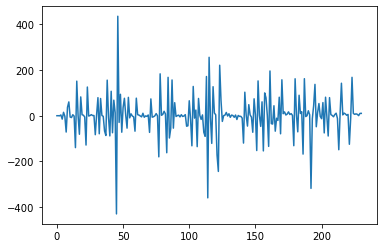

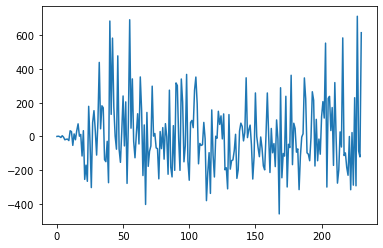

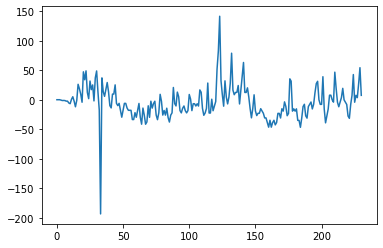

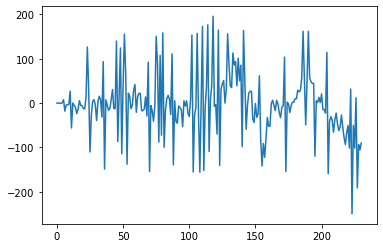

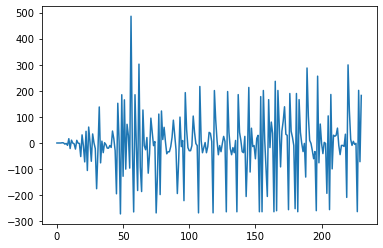

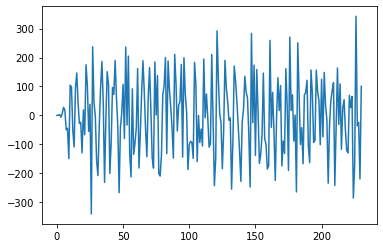

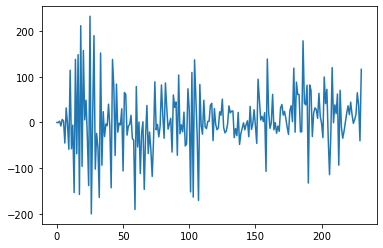

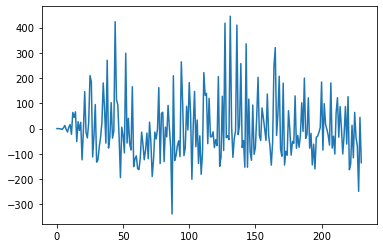

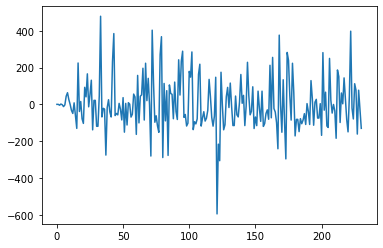

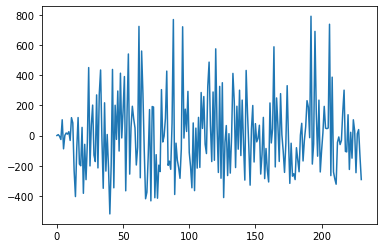

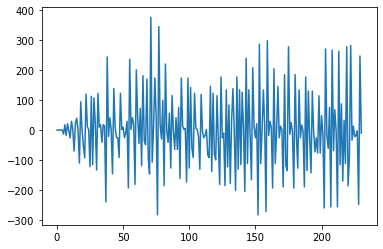

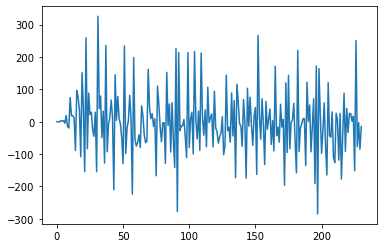

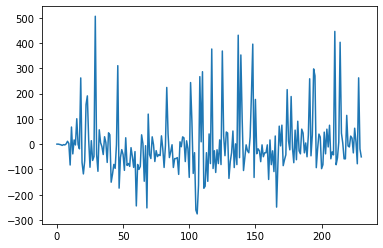

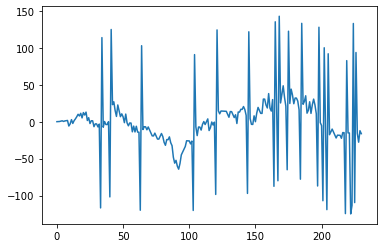

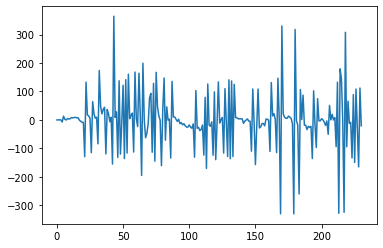

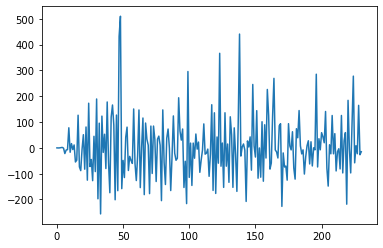

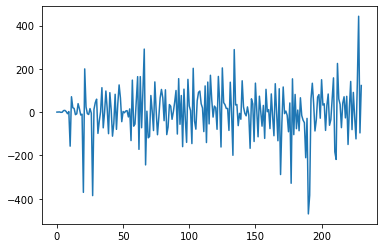

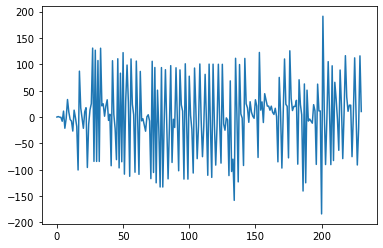

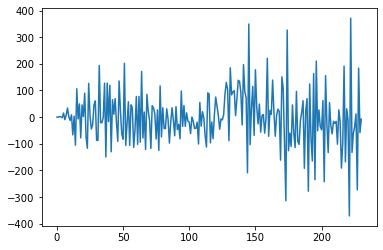

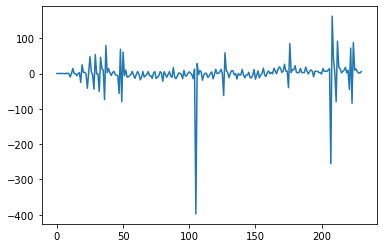

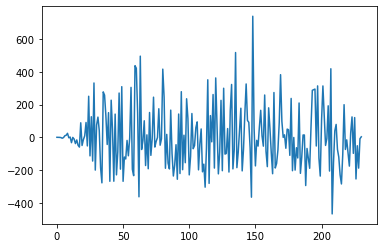

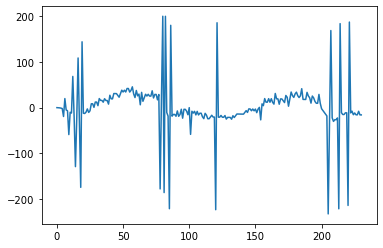

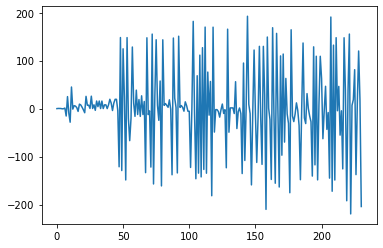

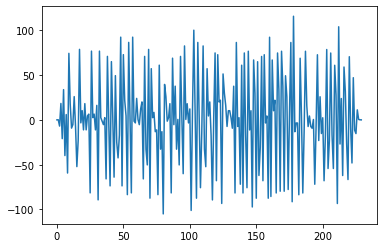

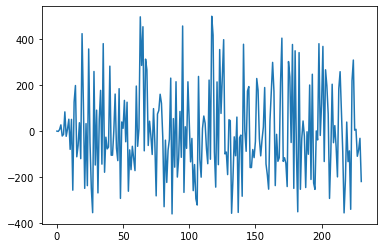

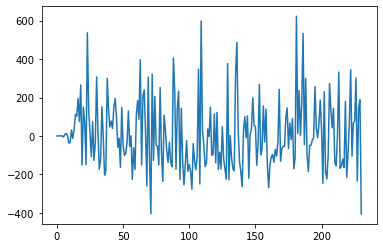

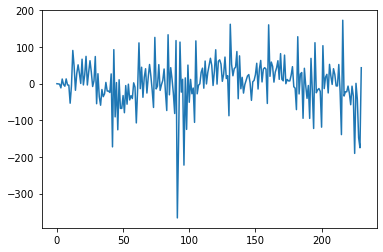

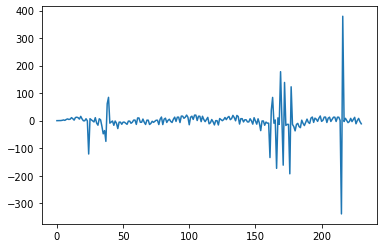

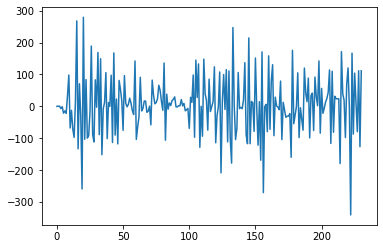

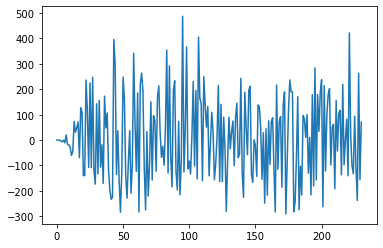

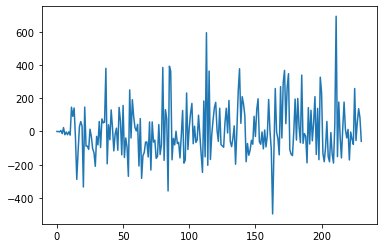

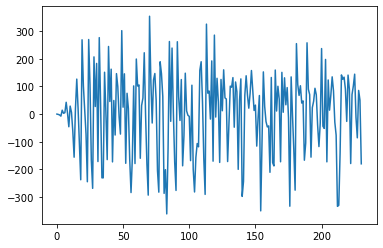

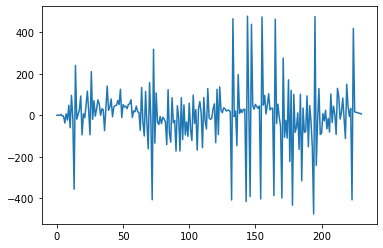

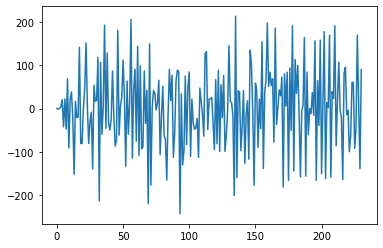

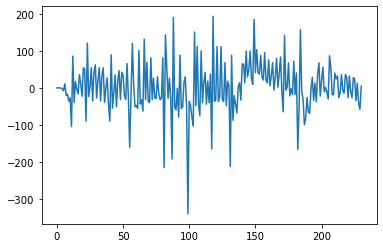

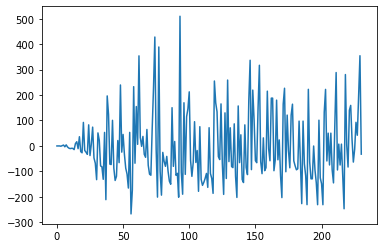

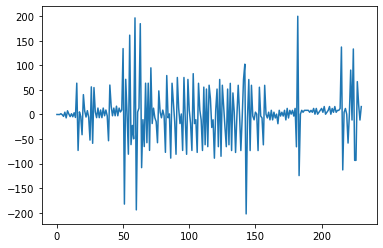

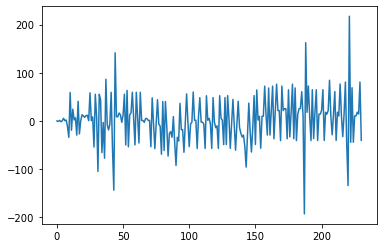

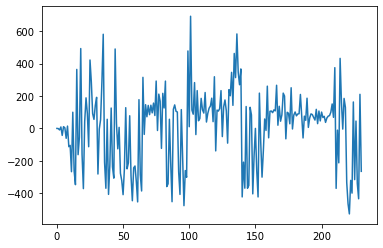

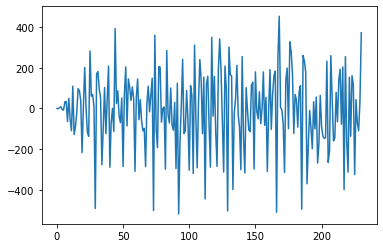

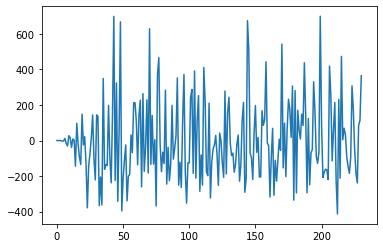

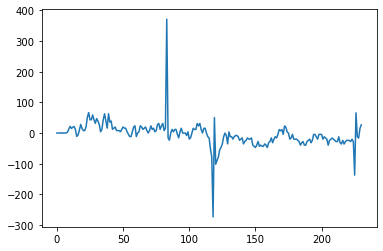

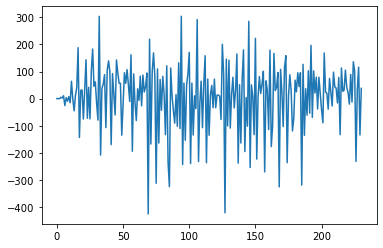

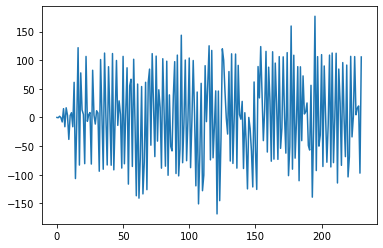

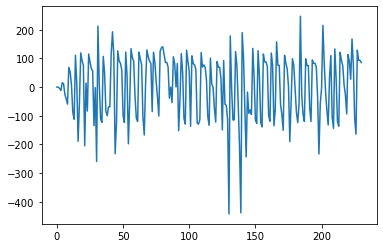

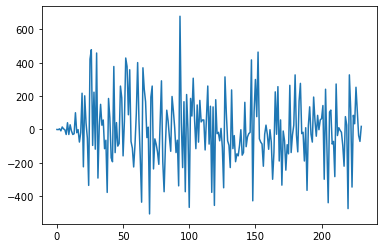

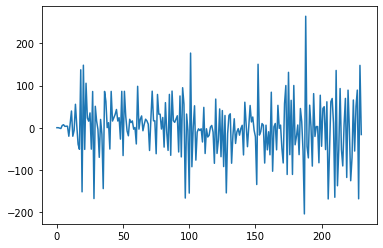

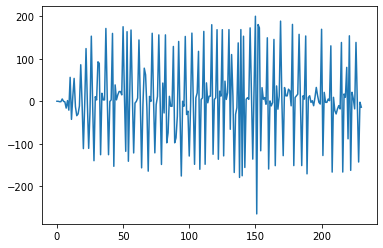

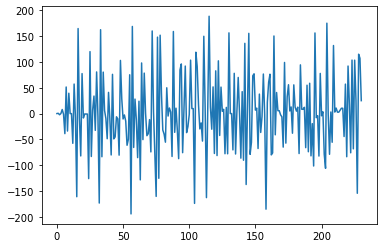

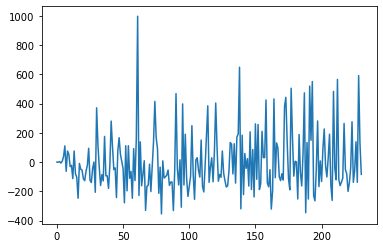

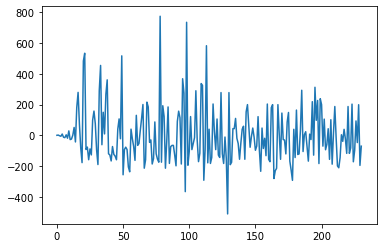

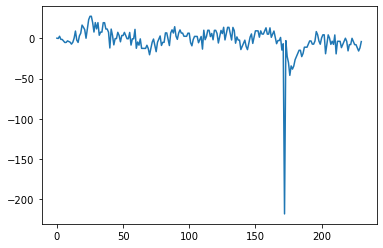

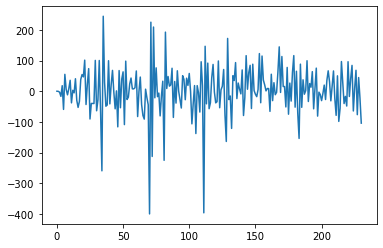

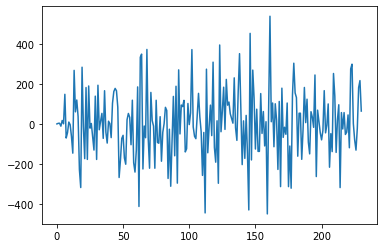

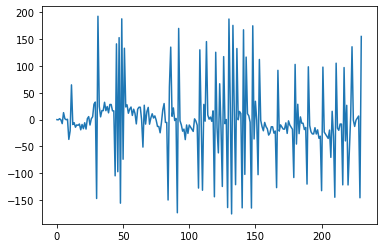

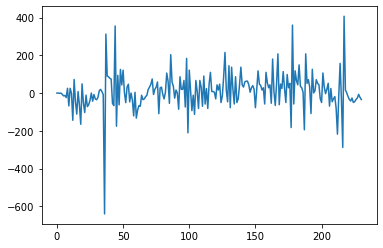

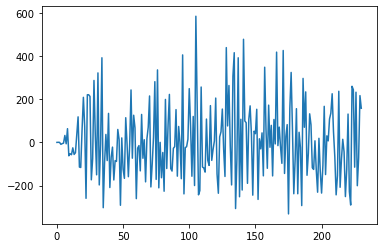

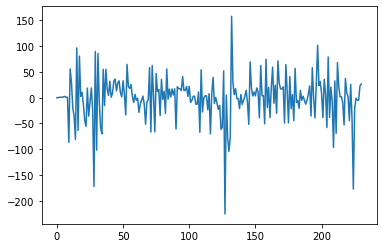

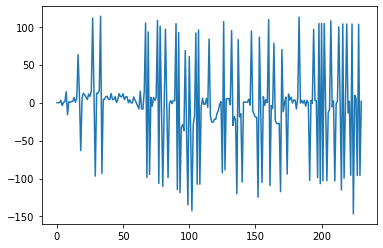

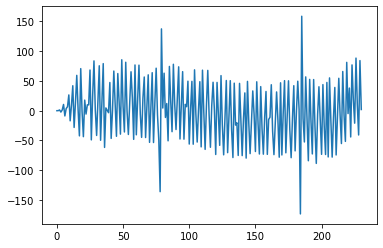

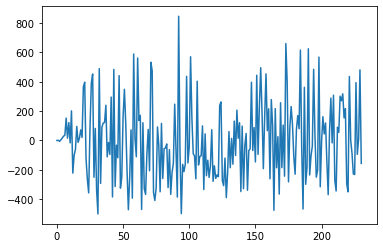

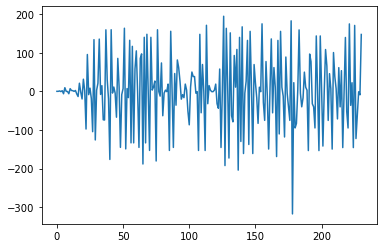

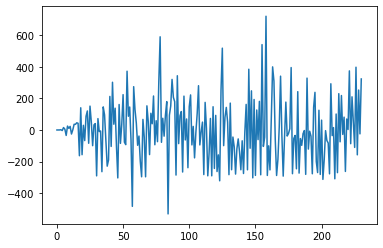

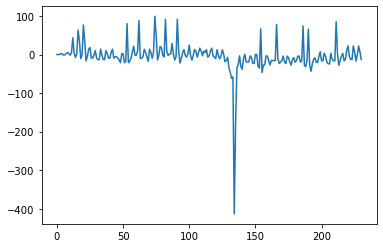

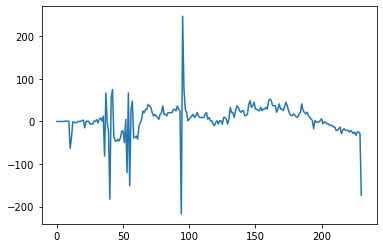

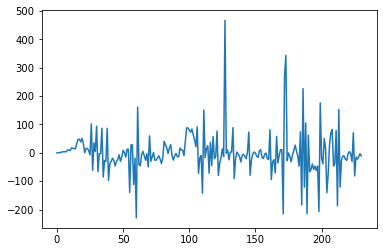

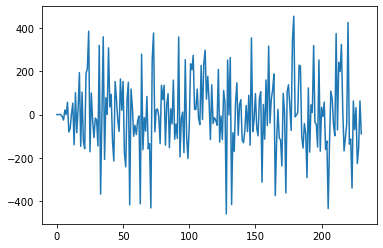

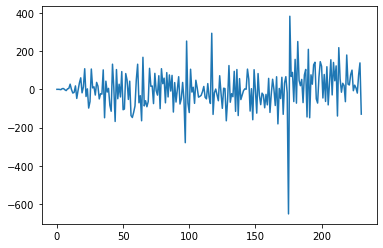

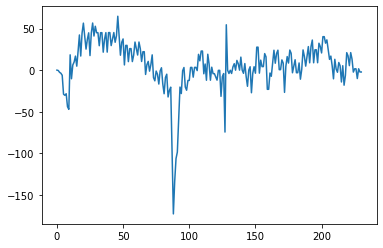

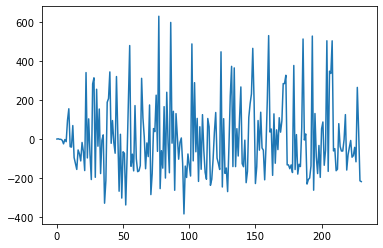

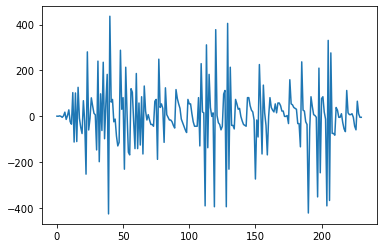

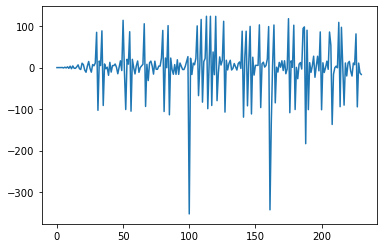

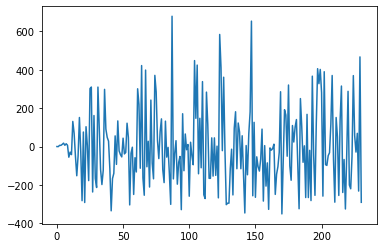

In [14]:
for i in range(100):
    plt.plot(stacked_x[i])
    plt.show()

## comparison of two dataset:

Now we will to try visualize spectograms. So far we have used Obspy to visualize SCG signals. However, with obspy we are not able to plot spectograms side by side. This is important for us because we want to see spectograms of x,y and z components simultaneously for both healty and diseased people. So, from now on I will refer to those plots, for 3 components of healty and diseased (in total six plot, as "PAIR").


I have mentioned that Obpsy has a problem in side by side plotting. So I changed it's source code. 

Thats why from now on we are going to use **output_spectogram** function to get the coefficients needed to plot spectogram.

These are the imports needed for output_spectogram function to work.

In [15]:
from obspy.imaging.cm import obspy_sequential
import math
from matplotlib import mlab
from matplotlib.colors import Normalize

In [16]:
def _nearest_pow_2(x):
    a = math.pow(2, math.ceil(np.log2(x)))
    b = math.pow(2, math.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

In [17]:
def output_spectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, cmap=obspy_sequential, zorder=None, title=None,
                show=True, clip=[0.0, 1.0]):
 
    import matplotlib.pyplot as plt
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    # Here we call not plt.specgram as this already produces a plot
    # matplotlib.mlab.specgram should be faster as it computes only the
    # arrays
    # XXX mlab.specgram uses fft, would be better and faster use rfft
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]
    
    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)

    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0

    # argument None is not allowed for kwargs on matplotlib python 3.3
    kwargs = {k: v for k, v in (('cmap', cmap), ('zorder', zorder))
              if v is not None}

    if log:
        # pcolor expects one bin more at the right end
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        # center bin
        time -= halfbin_time
        freq -= halfbin_freq
        # Log scaling for frequency values (y-axis)
        ax.set_yscale('log')
        # Plot times
        ax.pcolormesh(time, freq, specgram, norm=norm, **kwargs)
    else:
        # this method is much much faster!
        specgram = np.flipud(specgram)
        # center bin
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
    return [specgram, extent, end]

    



specgram : array-like


        2D array, columns are the periodograms of successive segments.

In [18]:
import scipy.signal

In [19]:
for i in range(len(stacked_x)):
    print( output_spectrogram(stacked_x[i].data, stacked_x[i].stats.sampling_rate, wlen=10)[0].shape)

(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)
(128, 50)


In [20]:
from sklearn.manifold import TSNE

In [54]:
tsne = TSNE(random_state =42, perplexity = 30, init = "pca", learning_rate = 50, n_iter = 5000)

In [22]:
x = []
for i in range(len(stacked_x)):
    x.append(output_spectrogram(stacked_x[i].data, stacked_x[i].stats.sampling_rate, wlen=10)[0])
#x (100,128,50)

In [23]:
x = np.array(x)
x.shape

(100, 128, 50)

In [24]:
column = np.vstack((np.zeros((73,128,1)),np.ones((27,128,1))))

In [25]:
column.shape

(100, 128, 1)

In [26]:
x = np.append(x, column, axis = -1)
x.shape

(100, 128, 51)

In [55]:
t = []
for i in range(len(stacked_x)):
    t.append(tsne.fit_transform(x[i]))

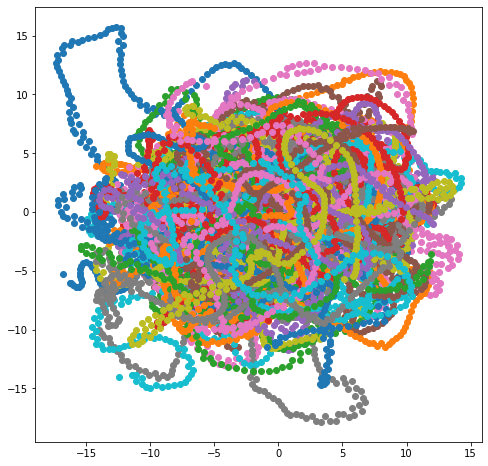

In [56]:
t = np.array(t)
f = plt.figure(figsize=(8, 8))
for i in range(len(stacked_x)):
    ax = plt.subplot()
    sc = ax.scatter(t[i][:,0], t[i][:,1])

        
plt.show()